In [1]:
suppressMessages(library("rwwa"))

# Obs

In [12]:
varnm <- "tn14x"
nsamp <- 1000

In [13]:
# load GMST time series (annual, 4-year smoothed)
gmst <- read.table("ts/gmst.txt", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2025]

cov_f <- gmst[gmst$year == 2025,"gmst",drop = F]
cov_cf <- rbind("pi" = cov_f - 1.3,
                "2000" = cov_f - 0.65,
                "2018" = gmst$gmst[gmst$year == 2018])

## Fit model

In [14]:
fl <- list.files("ts", pattern = varnm, full.names = T)
for (fnm in fl) {
    print(fnm)

    res_fnm <- gsub(".dat", ".csv", gsub("ts/", "res/res-obs_",fnm))
    if(file.exists(res_fnm)) next
    df <- merge(gmst, load_ts(fnm, col.names = c("year", "tmax")))

    mdl <- fit_ns("gev", "shift", df, "tmax", "gmst")

    if (max(df$year) < 2025) {
        rp <- switch(varnm, "tx14x" = 100, "tn14x" = 5)
        rl_ev <- eff_return_level(mdl, rp = rp, fixed_cov = cov_f)
        mdl <- fit_ns("gev", "shift", df, "tmax", "gmst", ev = rl_ev, ev_year = 2025)
    }

    res <- boot_ci(mdl, cov_f = cov_f, cov_cf = cov_cf, nsamp = nsamp)
    write.csv(res, res_fnm)

    png(gsub("csv", "png", gsub("res/", "fig/", res_fnm)), h = 360, w = 360 * 3); {
        prep_window(c(1,3))
        plot_trend(mdl, ev_year = 2025)
        plot_covtrend(mdl, "gmst", ci_cov = rbind(cov_f, cov_cf), nsamp = 100, ev_x = 0)
        plot_returnlevels(mdl, cov_f, cov_cf["pi",,drop = F])
    }; dev.off()
}

[1] "ts/fs-heatwave_tn14x_cpc.dat"
[1] "ts/fs-heatwave_tn14x_eobs.dat"
[1] "ts/fs-heatwave_tn14x_era5.dat"


## Compile obs results

In [23]:
varnm = "tn14x"

res_obs <- t(sapply(list.files("res", pattern = varnm, full.names = T), function(fnm) {
    res <- read.csv(fnm, row.names = "X")
    unlist(lapply(rownames(res), function(cnm) setNames(res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))
}))

rownames(res_obs) <- gsub(".csv", "", sapply(strsplit(rownames(res_obs), "_"), "[", 4))
write.csv(res_obs, paste0("res-obs_",varnm,".csv"))

## Changes in 2018 event

In [12]:
return_period(mdl, df$tmax[df$year == 2018], fixed_cov = df[df$year == 2018,"gmst",drop = F])
return_period(mdl, df$tmax[df$year == 2018], fixed_cov = df[df$year == 2025,"gmst",drop = F])

[1] 31.61437

[1] 19.4353

In [19]:
prob_ratio(mdl, df$tmax[df$year == 2018], cov_cf = df[df$year == 2018,"gmst",drop = F], cov_f = df[df$year == 2025,"gmst",drop = F])
int_change(mdl, df$tmax[df$year == 2018], cov_cf = df[df$year == 2018,"gmst",drop = F], cov_f = df[df$year == 2025,"gmst",drop = F])

[1] 1.626647

[1] 0.4139457

# Quick synthesis of obs only

In [ ]:
res_obs <- read.csv("res-obs_tx14x.csv", row.names = "X")
nobs <- nrow(res_obs)

,dI,PR
,<chr>,<chr>
cpc,"4.4 (1.82, 6.94)","1.55e+32 (14.7, 1.8e+125)"
eobs,"2.02 (0.86, 3.27)","5.27e+08 (7.92, 1.55e+32)"
era5,"2.66 (0.97, 4.34)","1.55e+32 (3.95, 9.29e+126)"
Synthesised,"3.03 (0.01, 6.05)","2.33e+24 (8.31e-12, 4.41e+99)"


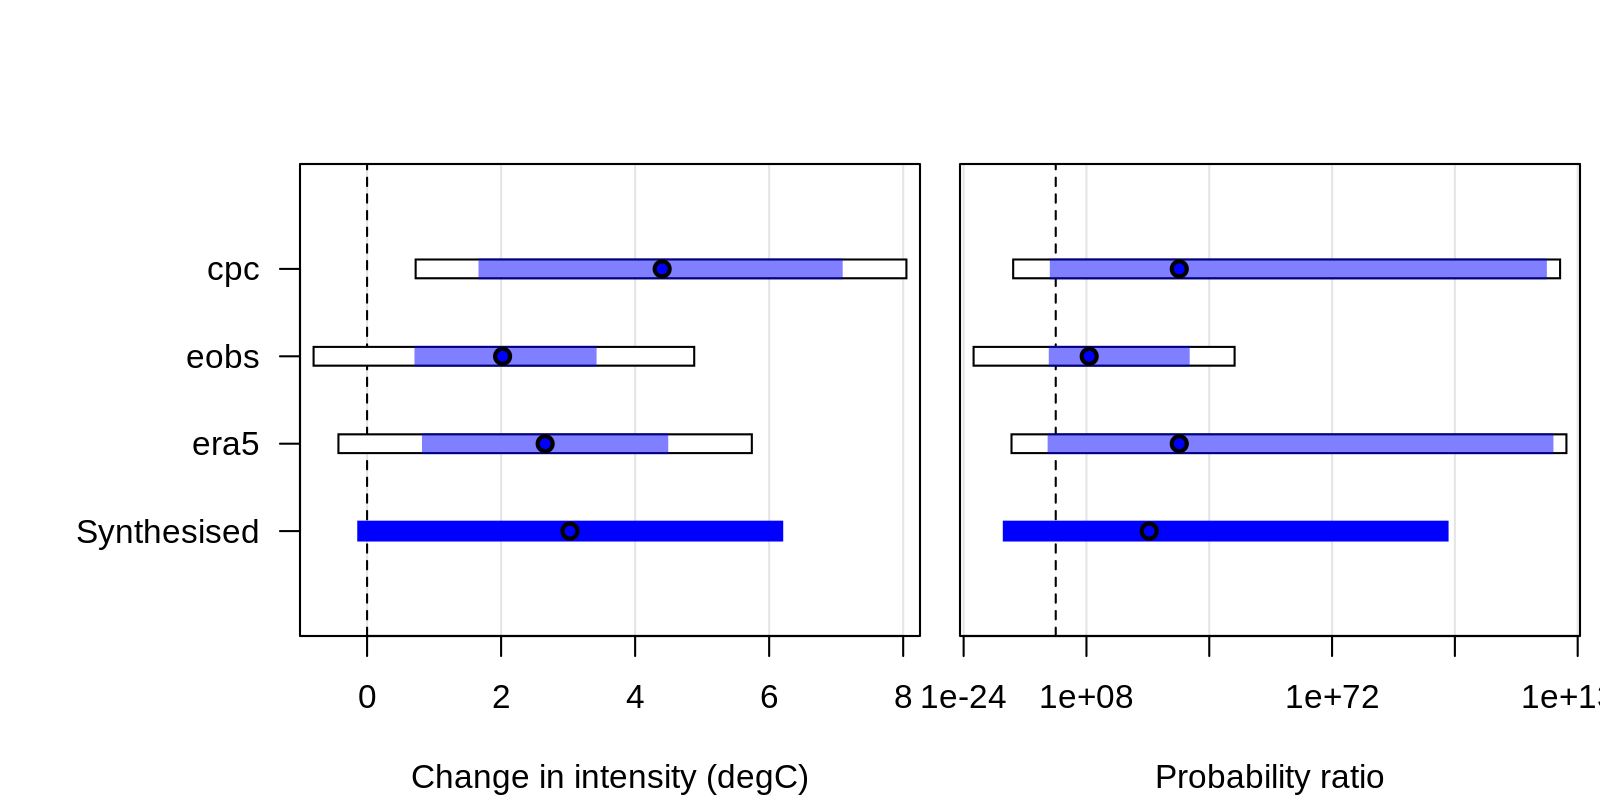

In [36]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# run synthesis
res_dI <- data.frame(res_obs[,grepl("dI.abs.pi", colnames(res_obs))])
synth_dI <- synthesis(obs_in = res_dI, models_in = res_dI, synth_type = "abs")$df[1:(nobs+1),3:7]

res_pr <- infer_infinite(data.frame(res_obs[,grepl("PR.pi", colnames(res_obs))]))
synth_pr <- synthesis(obs_in = res_pr, models_in = res_pr, synth_type = "PR")$df[1:(nobs+1),3:7]

nobs <- nrow(res_dI)

data.frame("dI" = apply(round(synth_dI[,1:3], 2), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
           "PR" = apply(signif(synth_pr[,1:3], 3), 1, function(r) paste0(r[1], " (",r[2], ", ", r[3], ")")),
                 row.names = c(rownames(res_obs), "Synthesised"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
prep_window(c(1,2), oma = c(0,7,0,0), mar = c(4.1,0.5,4.1,0.5))
yy <- (nobs+1):1

matplot(synth_dI, yy, type = "n", ylim = c(0,nobs+2), xlab = "Change in intensity (degC)", ylab = "", yaxt = "n")
axis(2, at = yy, labels = c(rownames(res_obs), "Synthesised"), las = 1)

grid(ny = NA, col = adjustcolor("black", 0.1), lty = 1)
abline(v = 0, lty = 2)
segments(y0 = yy, x0 = synth_dI$l_wb, x1 = synth_dI$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = yy, x0 = synth_dI$l_wb, x1 = synth_dI$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = yy, x0 = synth_dI$lower, x1 = synth_dI$upper, lwd = 10, col = mapply(adjustcolor, "blue", c(rep(0.5,nobs),1)), lend = 2)
points(synth_dI$est, yy, pch = 21, bg = "blue", lwd = 2)


matplot(synth_pr, yy, type = "n", ylim = c(0,nobs+2), xlab = "Probability ratio", ylab = "", yaxt = "n", log = "x")
grid(ny = NA, col = adjustcolor("black", 0.1), lty = 1)
abline(v = 1, lty = 2)
segments(y0 = yy, x0 = synth_pr$l_wb, x1 = synth_pr$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = yy, x0 = synth_pr$l_wb, x1 = synth_pr$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = yy, x0 = synth_pr$lower, x1 = synth_pr$upper, lwd = 10, col = mapply(adjustcolor, "blue", c(rep(0.5,nobs),1)), lend = 2)
points(synth_pr$est, yy, pch = 21, bg = "blue", lwd = 2)

---

# Quantile regression - how is temperature distribution changing?

In [38]:
suppressMessages(library(quantreg))

In [39]:
ts <- read.csv("data/tx-daily_era5.csv")
ts$year <- substr(ts$time,1,4)
ts <- merge(ts, gmst)

In [40]:
qq <- seq(0.05,0.95,0.1)
qrfit <- qrfit <- rq(tmax ~ gmst, data = ts, tau = qq)
qr_ests <- predict(qrfit, newdata = gmst)
res <- summary(qrfit, se = "boot", covariance = T)

In [41]:
coef <- sapply(res, "[", "coefficients")
beta <- sapply(coef,"[","gmst","Value")
beta_se <- sapply(coef,"[","gmst","Std. Error")

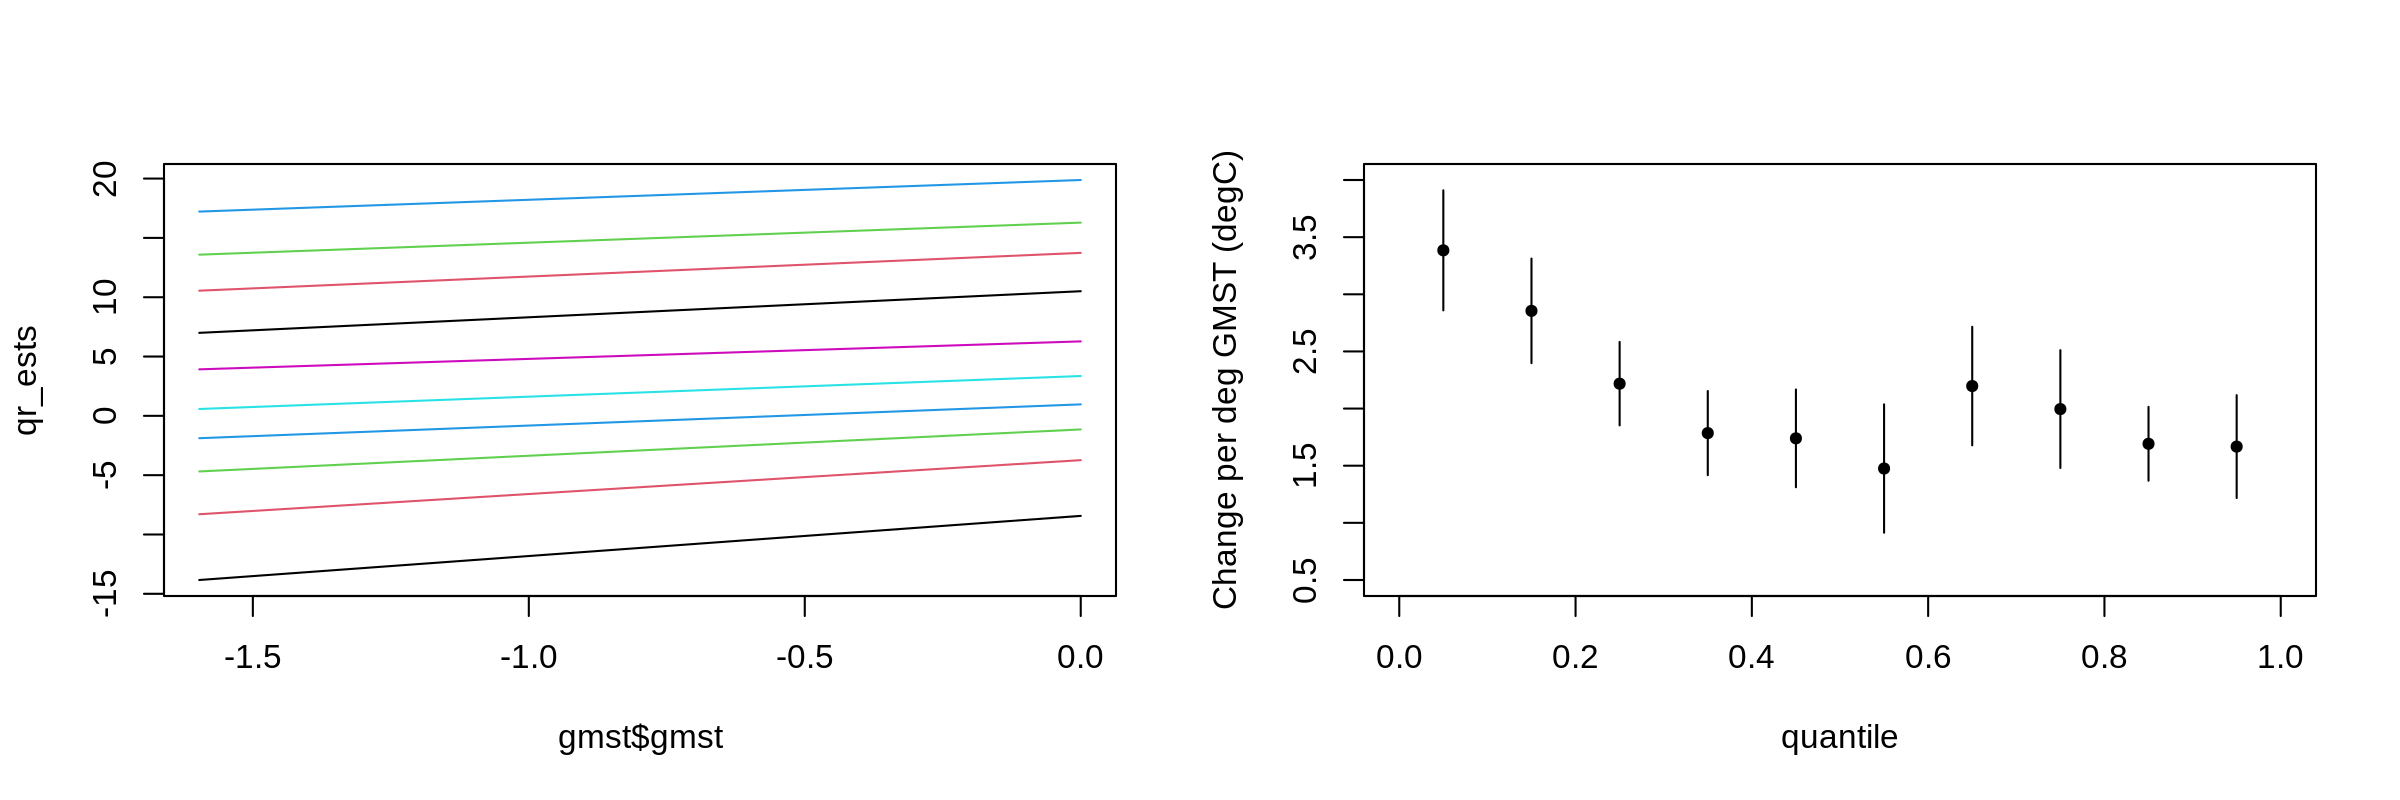

In [42]:
prep_window(c(1,2), w = 6)
matplot(x = gmst$gmst, qr_ests, type = "l", lty = 1)

plot(qq, beta, xlim = c(0,1), ylim = range(pretty(c(beta + (1.96 * beta_se), beta - (1.96 * beta_se)))),
     xlab = "quantile", ylab = "Change per deg GMST (degC)")
segments(x0 = qq, y0 = beta - (1.96 * beta_se), y1 = beta + (1.96 * beta_se))